# Applied Mathematics 115: Mathematical Modeling  
---
*2024 Spring / Full Term*

**Meeting Time:**  
Tuesday 10:30 AM - 11:45 AM  
Thursday 10:30 AM - 11:45 AM
<br>
<br>

**Instructors:**  
*Michael P. Brenner* (Pierce Hall 313) brenner@seas.harvard.edu  
Francesco Mottes fmottes@seas.harvard.edu  

**Teaching Fellows:**  
Henry Bae henrybae@college.harvard.edu  
Sarah Martinson sarahmartinson@g.harvard.edu  
Shruti Sharma ssharma1@g.harvard.edu  
Al Shodiev alshodiev@college.harvard.edu  
Alex Sullivan alexsullivan@college.harvard.edu  
Matt Tibbitts mtibbitts@college.harvard.edu  





# Single elimination tournaments

In a single-elimination tournament, participants compete in a series of rounds, with each round consisting of matches between pairs of contestants. The loser of each match is immediately eliminated from the tournament, while the winner advances to the next round. This process continues until only one participant emerginges as the overall champion of the tournament. Single-elimination tournaments are commonly used in sports and other competitive events to determine a clear winner within a short period.

Taking inspiration from the previous models, we can imagine a vary basic way to model any tournament of this kind. Each two contestants $i$ and $j$ are associated with a probability $p_{ij}$ that contestant $i$ wins over contestant $j$ in a direct match. We then treat every direct match as a Bernoulli trial.

There are two major differences w.r.t. the Mosteller model we have seen before. The first (obvious) one is that each two teams play a single game against each other, the other is that the results of each elimination round affect the trials that are carried out in the successive round.

This makes it difficult to come up with a closed-form mathematical description of the probability of any team to win such competition. This is especially true if we want to include more and more effects, like home-field advantage or history-dependent probability of winning matches. The best option is then to simulate a lot of tournaments and come up with numerical estimates.

For a tournament with $n$ teams, the matrix $P=\{p_{ij}\}$ of pairwise probabilities of victory will have the form:

$$
\begin{bmatrix}
p_{11} & p_{12} & \cdots & p_{1n} \\
p_{21} & p_{22} & \cdots & p_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
p_{n1} & p_{n2} & \cdots & p_{nn} \\
\end{bmatrix}
$$


# Basic Model - 4 teams

We start by making two assumptions that simplify the model a lot.

The first one is that we are given a draw for the tournament, so the only stochasticity will be given by the results of the matches and not by the initial configuration of participants.

The second one is that the probabilities of winning matches are matched, that is $p_{ji} = 1-p_{ij}$. What this means in practice is that we are not accounting for possible effects related to the order of the draw and only which teams are playing matter. This need not apply, for example if you want to consider home advantage (home teams/players are usually listed first, so that $p_{ij}$ would mean "home game for team $i$"). If you consider home advantage, for example, then you would have $p_{ji} > 1 - p_{ij}$.

We consider a random draw, that will be fixed throughout the simulation. Then we generate some random probabilities of victory and simulate the tournament to estimate the proability of team $i$ winning the tournament.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

## Draw

In [ ]:
N = 4 #number of teams

#generate random draw
draw = np.arange(N)
np.random.shuffle(draw)

#group teams 2 by 2
initial_matches = draw.reshape(2,-1).tolist()

print(initial_matches)

[[0, 3], [2, 1]]


## Pairwise Winning Probabilities

In [ ]:
#generate random P matrix
P = np.random.uniform(size=(N,N))

#zero out lower part of the matrix
P = np.triu(P)

# set low triangular part to p_ji = 1-p_ij
P += np.tril(1-P.T)

#for sake of consistency, we set main diagonal to p_ii = 1-p_ii = .5 (has no practical effect)
P[np.diag_indices(P.shape[0])] = .5

print(P)

[[0.5        0.91279635 0.3770487  0.88455204]
 [0.08720365 0.5        0.73024977 0.61602974]
 [0.6229513  0.26975023 0.5        0.98376566]
 [0.11544796 0.38397026 0.01623434 0.5       ]]


We can also visualize the matrix of pairwise probabilities as a heatmap

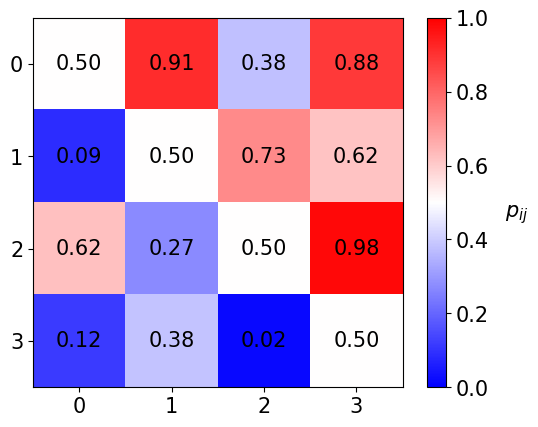

In [ ]:
heatmap = plt.imshow(P, cmap='bwr', vmin=0., vmax=1.)

cbar = plt.colorbar()
cbar.set_label(r'$p_{ij}$', rotation=0, labelpad=20)

# Set integer ticks for both axes
plt.xticks(np.arange(N), np.arange(N))
plt.yticks(np.arange(N), np.arange(N))

for i in range(N):
    for j in range(N):
        plt.text(j, i, f'{P[i, j]:.2f}', ha='center', va='center', color='black')



## Tournament simulation

In [ ]:
def simulate_4team_tournament(draw, P):
    '''
    Simple simulation of a tournament with 4 teams.

    Args
    ----

    draw : list[int]
            List of initial team pairings.
    P : np.ndarray
        Square matrix with pairwise winning probabilities.
    '''

    final = []

    #elimination rounds
    for i,j in draw:
        win_i = bool(np.random.uniform() < P[i,j])

        if win_i:
            final.append(i)
        else:
            final.append(j)

    #final
    i, j = final
    win_i = bool(np.random.uniform() < P[i,j])

    winner = i if win_i else j

    return [draw,final,winner]

In [ ]:
simulate_4team_tournament(initial_matches, P)

[[[0, 3], [2, 1]], [0, 1], 0]

We can now simulate an ensemble of tournaments and record the results. We can then use these results to estimate the overall probability of a team winning the tournament given the current draw.

In [ ]:
#counts occurrences of objects and returns dictionary with counts
from collections import Counter

n_trials = 1000

#carry out a number of simulated tournaments
winners = []
for _ in range(n_trials):
    _, _, winner = simulate_4team_tournament(initial_matches, P)
    winners.append(winner)


#count victories
dict_wins = Counter(winners)

In [ ]:
dict_wins

Counter({0: 672, 2: 166, 1: 121, 3: 41})

In [ ]:
#calculate and print winning probabilities
print('Tournament winning probabilities:')
print('---------------------------------\n')

for team in sorted(dict_wins):

    p = dict_wins[team] / n_trials

    print(f'Team {team}:\t{p:.3f}')

Tournament winning probabilities:
---------------------------------

Team 0:	0.672
Team 1:	0.121
Team 2:	0.166
Team 3:	0.041


## Effect of initial draw

We'll now use the code above to estimate the winning probability of each team for each of the possible initial draws.

It turns out that, unsurprisingly, the initial draw has a big impact on the overall probability of winning the tournament.

In [ ]:
#for simplicity define a new function
def simulate_ensemble(draw, P, n_trials):

    #carry out a number of simulated tournaments
    winners = []
    for _ in range(n_trials):
        winner = simulate_4team_tournament(draw, P)[-1]
        winners.append(winner)

    #count victories
    dict_wins = Counter(winners)

    return dict_wins

In [ ]:
possible_draws = [
    [[0,1],[2,3]],
    [[0,2],[1,3]],
    [[0,3],[1,2]]
]

In [ ]:
#trials per draw
n_trials = 10000

team_p = {0:[], 1:[], 2:[], 3:[]}

for draw in possible_draws:
    d_wins = simulate_ensemble(draw, P, n_trials)

    #update p dict
    for team in d_wins:
        team_p[team] += [d_wins[team]/n_trials]

In [ ]:
team_p

{0: [0.3488, 0.3409, 0.6774],
 1: [0.0679, 0.3072, 0.1094],
 2: [0.5809, 0.3326, 0.1798],
 3: [0.0024, 0.0193, 0.0334]}

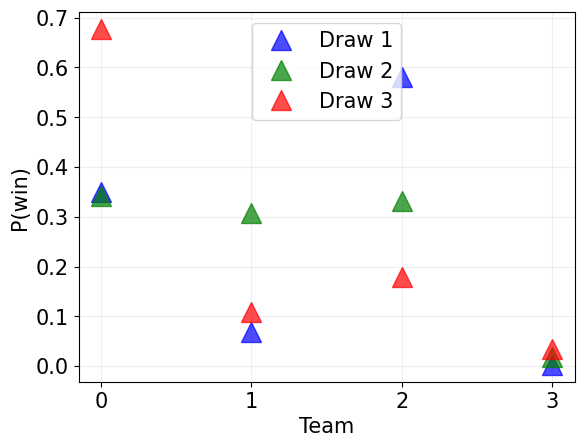

In [ ]:
for team in team_p:
    for winp,color in zip(team_p[team],['b','g','r']):
        plt.plot([team],[winp], color+'^', markersize=15, alpha=.7)

plt.xticks(np.arange(N), np.arange(N))
plt.grid(alpha=.2)

plt.xlabel('Team')
plt.ylabel('P(win)')

#quick trick to add legend without repetitions (empty plots)
plt.plot([], [], 'b^', alpha=.7, markersize=15, label='Draw 1')
plt.plot([], [], 'g^', alpha=.7, markersize=15, label='Draw 2')
plt.plot([], [], 'r^', alpha=.7, markersize=15, label='Draw 3')

plt.legend(loc='upper center');

# (Stub) Estimate Pairwise Probabilities from Data

When modelling an actual tournament, we are usually given the initial draw or at least the partecipating teams. The information that's usually missing and that's at the core of the whole approach is, once again, the one about pairwise wining probabilities. For lack of better options, we can assume that these do not change too much in time and try to infer them from past matches between two teams.

The most crude approach is again to treat each past match as a bernoulli trial, then take the average of the results as the best approximation for $p_{ij}$.

In [ ]:
# uncomment to clone gh repo easier access to data
!git clone https://github.com/fmottes/Harvard-AM115-2024.git

DATA_PATH = 'Harvard-AM115-2024/Homework/HW1/'

Cloning into 'Harvard-AM115-2024'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (33/33), 795.50 KiB | 8.84 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
import pandas as pd

#homework file with data
with open(DATA_PATH+'HW1-P4-Tournament4Teams_PrevMatches.csv', 'r') as fh:
    tournament_history = pd.read_csv(fh)

In [ ]:
tournament_history

,TeamA,TeamB,Result
0,2,0,0
1,3,1,0
2,2,1,0
3,2,3,1
4,1,2,0
...,...,...,...
179,1,0,0
180,3,1,0
181,0,2,1
182,0,3,1


**NOTE1:** Teams and matches are not guaranteed to appear in any specific order in the file. This means that you will find (for example) matches indexed as (0,3) but also as (3,0). If we ignore the order in our estimate, those two should contribute to the same $p_{03}$.

**NOTE2:** If you reorder the first two columns to make counting matches easier, remember to keep the result consistent! E.g. if you switch a (3,0) match with result 1 into a (0,3) the new result is now 0!!!


# ELO Ratings and Win probabilities

The ELO rating system gives a way of computing the probability that team $i$ beats team $j$ by giving each team a _score_, the so-called ELO score. Given ELO scores $R_i$ and $R_j$ for the two teams, the win probability is
$$p_{i,j} = \frac{1}{1+10^{(R_i-R_j)/40}}.$$

Thus given a list of ELO scores we can compute the pair probability matrix $P$ discussed above and redo our simulations.

For fun, lets take the [ELO scores](https://neilpaine.substack.com/p/2023-nfl-elo-ratings-and-win-projections) for the NFL playoffs from Neil Paine (who used to work at 538), and simulate this years NFL playoffs from the divison finals onwards.

|Team Number| Team Name | ELO Score |
|---| --- | --- |
|0| 49ers | 1719 |
|1|  Lions| 1605 |
|2 | Ravens | 1685 |
|3 |Chiefs| 1689|

In [ ]:
draw=[[0,1],[2,3]]
elo_scores = [1719,1605,1685,1689]
N = len(elo_scores)

In [ ]:
def convert_elo_to_pair_probabilities(elo_scores, S=400):
    """
    Converts a list of ELO scores to a matrix of pairwise winning probabilities.

    Args:
        elo_scores: A list of ELO scores for each team.

    Returns:
        A NumPy array of pairwise winning probabilities.
    """

    # Create an empty matrix to store the probabilities.
    probabilities = np.zeros((len(elo_scores), len(elo_scores)))

  # Calculate the probability of each team winning against each other team.
    for i in range(len(elo_scores)):

        probabilities[i, i] = 0.5

        for j in range(i + 1, len(elo_scores)):
            # Calculate the expected score difference.
            expected_score_diff = (elo_scores[i] - elo_scores[j]) / S

            # Calculate the probability of team i winning.
            probability_i = 1 / (1 + 10**(-expected_score_diff))

            # Set the probabilities for both i vs j and j vs i (since they are equivalent).
            probabilities[i, j] = probability_i
            probabilities[j, i] = 1 - probability_i

    return probabilities

In [ ]:
#pairwise prob. matrix
P = convert_elo_to_pair_probabilities(elo_scores)

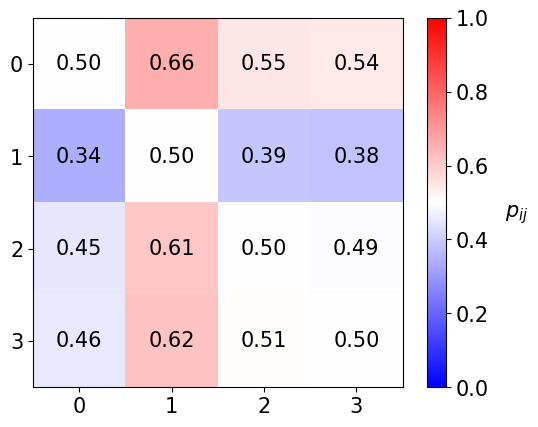

In [ ]:
heatmap = plt.imshow(P, cmap='bwr', vmin=0., vmax=1.)

cbar = plt.colorbar()
cbar.set_label(r'$p_{ij}$', rotation=0, labelpad=20)

# Set integer ticks for both axes
plt.xticks(np.arange(N), np.arange(N))
plt.yticks(np.arange(N), np.arange(N))

for i in range(N):
    for j in range(N):
        plt.text(j, i, f'{P[i, j]:.2f}', ha='center', va='center', color='black')

In [ ]:
dict_wins = simulate_ensemble(draw, P, n_trials=10000)

In [ ]:
print('Tournament winning probabilities:')
print('---------------------------------\n')

for team in sorted(dict_wins):

    p = dict_wins[team] / n_trials

    print(f'Team {team}:\t{p:.3f}')

Tournament winning probabilities:
---------------------------------

Team 0:	0.369
Team 1:	0.126
Team 2:	0.245
Team 3:	0.260


# Elo Ratings from data

While in the section above we used scores that were pre-computed for us by someone else, nothing forbids that we calculate our own scores starting from the historical data of wins and losses. That's what we will do in this section, using the results of the games played in the regular NFL season of 2023.

## Load NFL 2023 results

In [ ]:
!git clone https://github.com/fmottes/Harvard-AM115-2024.git

DATA_PATH = 'Harvard-AM115-2024/Data/'

Cloning into 'Harvard-AM115-2024'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (44/44), 1.47 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
import pandas as pd

#homework file with data
with open(DATA_PATH+'L04-NFL2023.csv', 'r') as fh:
    nfl_games = pd.read_csv(fh)

#consider only regular season (18 weeks)
nfl_games = nfl_games[:272]

In [ ]:
nfl_games

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,2023-09-07,8:20PM,Detroit Lions,@,Kansas City Chiefs,boxscore,21.0,20.0,368.0,1.0,316.0,1.0
1,1,Sun,2023-09-10,1:00PM,Atlanta Falcons,NaN,Carolina Panthers,boxscore,24.0,10.0,221.0,0.0,281.0,3.0
2,1,Sun,2023-09-10,1:00PM,Cleveland Browns,NaN,Cincinnati Bengals,boxscore,24.0,3.0,350.0,2.0,142.0,0.0
3,1,Sun,2023-09-10,1:00PM,Jacksonville Jaguars,@,Indianapolis Colts,boxscore,31.0,21.0,342.0,2.0,280.0,3.0
4,1,Sun,2023-09-10,1:00PM,Washington Commanders,NaN,Arizona Cardinals,boxscore,20.0,16.0,248.0,3.0,210.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,18,Sun,2024-01-07,4:25PM,Las Vegas Raiders,NaN,Denver Broncos,boxscore,27.0,14.0,359.0,0.0,286.0,1.0
268,18,Sun,2024-01-07,4:25PM,Kansas City Chiefs,@,Los Angeles Chargers,boxscore,13.0,12.0,268.0,1.0,353.0,1.0
269,18,Sun,2024-01-07,4:25PM,New York Giants,NaN,Philadelphia Eagles,boxscore,27.0,10.0,415.0,1.0,299.0,4.0
270,18,Sun,2024-01-07,4:25PM,Los Angeles Rams,@,San Francisco 49ers,boxscore,21.0,20.0,258.0,1.0,300.0,1.0


In [ ]:
#check no match ended in tie
n_ties = (nfl_games['PtsW']-nfl_games['PtsL'] == 0).sum()

print(f'Number of ties:\t{n_ties}')

Number of ties:	0


In [ ]:
teams = set(nfl_games['Winner/tie'].unique()) | set(nfl_games['Loser/tie'].unique())

print(f'Number of teams:\t{len(teams)}')

Number of teams:	32


## Calculate ELO Scores

In [ ]:
#define logistic function (utility)
def logistic(x):
    return 1 / (1 + 10**-x)

#given two ELO scores, compute P(A wins over B)
def expected_game_score(team_a_elo, team_b_elo, S=400):
    return logistic((team_a_elo - team_b_elo)/S)

In [ ]:
#set up initial elo scores - same for each team
INITIAL_ELO = 1500
team_elo = dict([(team,[INITIAL_ELO]) for team in sorted(teams)])

# learning constant - hyperparameter!!
K = 20

#loop through the data and update
#note that games are already ordered by date in the original dataset
for index, row in nfl_games.iterrows():

    winner = row['Winner/tie']
    loser = row['Loser/tie']

    #get latest elo scores
    elo_winner = team_elo[winner][-1]
    elo_loser = team_elo[loser][-1]

    #calculate prob of winning for each team
    p_winner = expected_game_score(elo_winner, elo_loser)
    p_loser = expected_game_score(elo_loser, elo_winner) #should be 1 - p_winner

    # calculate and append new elo scores to the list
    new_elo_winner = elo_winner + K * (1 - p_winner)
    new_elo_loser = elo_loser + K * (0 - p_loser)

    team_elo[winner].append(new_elo_winner)
    team_elo[loser].append(new_elo_loser)

In [ ]:
print("Final Elo Rankings:")
print("----------------------------------------------\n")

sorted_elo = sorted([(t,team_elo[t][-1]) for t in team_elo], key=lambda x: x[1], reverse=True)

for i, (t,e) in enumerate(sorted_elo):
    print(f'{i+1}\t{e:.2f}\t\t{t}')

Final Elo Rankings:
----------------------------------------------

1	1577.43		Baltimore Ravens
2	1557.34		Dallas Cowboys
3	1554.81		San Francisco 49ers
4	1553.09		Detroit Lions
5	1547.50		Buffalo Bills
6	1542.53		Cleveland Browns
7	1535.30		Miami Dolphins
8	1534.42		Kansas City Chiefs
9	1532.67		Los Angeles Rams
10	1529.32		Philadelphia Eagles
11	1526.49		Pittsburgh Steelers
12	1526.17		Houston Texans
13	1515.54		Cincinnati Bengals
14	1511.69		Green Bay Packers
15	1507.77		Seattle Seahawks
16	1507.32		Tampa Bay Buccaneers
17	1506.78		New Orleans Saints
18	1505.06		Indianapolis Colts
19	1500.44		Jacksonville Jaguars
20	1494.31		Las Vegas Raiders
21	1494.04		Denver Broncos
22	1481.34		Chicago Bears
23	1476.18		New York Jets
24	1473.04		Minnesota Vikings
25	1465.64		Atlanta Falcons
26	1465.42		New York Giants
27	1461.02		Tennessee Titans
28	1438.74		Los Angeles Chargers
29	1434.38		Arizona Cardinals
30	1428.51		New England Patriots
31	1421.81		Washington Commanders
32	1393.94		Carolina P

Compare the rankings with those from Neil Paine (not so bad!!):

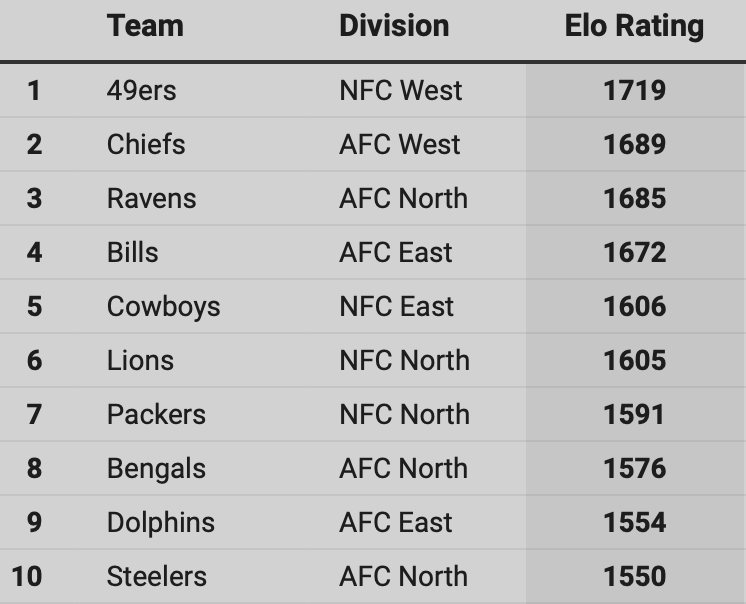

## (Stub) Analyze scores

The good thing of owning your own scores is that you can now bulid any pairwise probability matrix that you like using the code from previous sections!

Also you can plot how the score changes for each team with the number of games and (maybe?) identify interesting trends!


In [ ]:
div_finals_teams = [
    'San Francisco 49ers',
    'Detroit Lions',
    'Baltimore Ravens',
    'Kansas City Chiefs'
]


P_from_data =